Importing required libraries to predict acceleration using random forest, calculate RMSE (RootMeanSquaredError), and create plots to compare predicted and actual acceleration

In [92]:
import pandas as pd
import numpy as np
import FileProcessing
import ModelClass
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns



In [93]:
import random
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
from tensorflow.keras import layers


In [94]:
class ModelClass():

    '''
    '''

    def define_neural_network(self, input):

        #input = keras.Input(shape=(18,))
        input = keras.Input(shape=(4,))
        # Fully connected layers
        x = layers.Dense(128, activation='relu')(input)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(16, activation='relu')(x)
        # Softmax used for classifier problems
        outputs = layers.Dense(1, activation="softmax")(x)

        model = keras.Model(inputs=input, outputs=outputs)
        model.compile(optimizer='rmsprop',
                      loss='mean_squared_error',
                      metrics=['mean_squared_error'])
        model.summary()

        return model

    def fit_neural_network(self, model, X_train, y_train):
        model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)
        return model

    def create_prediction_pair(self, df, n):
        '''
        create the prediction pair by shifting the actual data up by the mentioned number(0.1*n seconds) to create the timeseries info
        '''
        df=self.tranformations_for_models(df)
        df["nextframeAcc"] = df.groupby(
            ["L-F_Pair"], as_index=False)["v_Acc"].shift(-1*n)
        df["nextframesvel"] = df.groupby(
            ["L-F_Pair"], as_index=False)["v_Vel"].shift(-1*n)
        df["nextframeposition"] = df.groupby(
            ["L-F_Pair"], as_index=False)["Local_Y"].shift(-1*n)
        df['nextframeposition'] = df['nextframeposition'].fillna(0)
        df['nextframesvel'] = df['nextframesvel'].fillna(0)
        df['nextframeAcc'] = df['nextframeAcc'].fillna(0)

        return df

    def tranformations_for_models(self, df):
        
        '''
        Read the input file into a dataframe.
        Input: File name for the file present in Data folder.
        Output: Dataframe name.
        '''
        df["Vehicle_combination_cat"] = df["Vehicle_combination"].astype("category").cat.codes
        df["Preceding_Vehicle_Class_cat"]=df["Preceding_Vehicle_Class"].astype("category").cat.codes
        df["Location_cat"]=df["Location"].astype("category").cat.codes
                                          
        drop_columns_list=['Vehicle_ID','Frame_ID','Global_Time','Local_X','Global_X','Global_Y','v_length','Lane_ID','Preceding','Space_Headway','Time_Headway','v_Class_Name','lane_changes','previous_car_lane_changes','Prec_Vehicle_ID','Vehicle_combination','Preceding_Vehicle_Class','Location','Relative_Time']
        df["Front_To_Rear_Time_Headway"] = df["Front_To_Rear_Time_Headway"].replace(np.inf, 999)
        df[df.select_dtypes(np.float64).columns]=df.select_dtypes(np.float64).astype(np.float32)
        df=df.drop(drop_columns_list,axis=1,errors='ignore')
        return df

    def test_train_pairs(self, df, split, seed):
        '''
        Read the input file into a dataframe.
        Input: File name for the file present in Data folder.
        Output: Dataframe name.
        '''
        
        
        random.seed(seed)
        #df = df.applymap(lambda x: float(round(x, 4))if isinstance(x, (int, float)) else x)
        total_pairs = df["L-F_Pair"].unique()
        total_pairs = total_pairs.tolist()
        test_split_cnt = round(len(total_pairs)*split)
        test_split_pairs = random.sample(total_pairs, test_split_cnt)
        train_df = df[df['L-F_Pair'].isin(test_split_pairs)]
        test_df = df[~df['L-F_Pair'].isin(test_split_pairs)]

        return train_df, test_df

    def prediction_test_pairs(self, df, pair_from, pair_to):
        unique_pairs_values = df['L-F_Pair'].unique()
        unique_pairs_list = unique_pairs_values.tolist()
        unique_pairs_df = unique_pairs_list[pair_from:pair_to]
        return unique_pairs_df

    def feature_selection(self, train_df, test_df):
        X_train = train_df[['Rear_to_Front_Space_Headway', 'Vehicle_combination_cat',
                            'Velocity Difference_Following-Preceding', 'v_Vel']]

        X_test = test_df[['Rear_to_Front_Space_Headway', 'Vehicle_combination_cat',
                          'Velocity Difference_Following-Preceding', 'v_Vel']]

        #X_train = train_df.drop(['v_Acc', 'L-F_Pair'], axis=1)
        y_train = train_df['nextframeAcc']
        #X_test = test_df.drop(['v_Acc', 'L-F_Pair'], axis=1)
        y_test = test_df['nextframeAcc']

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        return X_train, y_train, X_test, y_test

    

Loading the cleaned ngsim data using pandas

In [95]:
fileProcessing=FileProcessing.FileProcessing()

In [96]:
#model_obj=ModelClass.ModelClass()
model_obj=ModelClass()

In [97]:
file_name='Cleaned_NGSIM_Data'
ngsim=fileProcessing.read_input(file_name)

original File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\scripts
Data File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\data


In [98]:
ngsim[(ngsim['Vehicle_ID'] == 2876) & ( ngsim['Global_Time'] == 1118847795200) ].filter(like='pre')

,preceding_vehicle_length,previous_Vehicle_Velocity,previous_Vehicle_Acceleration,previous_car_lane_changes,previous_Local_Y
57023,3.9624,0.0,0.0,False,NaN


Adding new columns nextframe acceleration, velocity, and position which will be our target features.

In [59]:
ngsim=model_obj.create_prediction_pair(ngsim,1)

In [60]:
ngsim

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,...,previous_Vehicle_Acceleration,previous_Local_Y,pair_Time_Duration,total_pair_duration,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat,nextframeAcc,nextframesvel,nextframeposition
0,34.445000,2,9.424416,0.000000,12.489688,1.325248,9.424416,0.000000,13-22,4.52120,...,0.0,NaN,0.000000,41.599998,0,0,1,0.000000,9.424416,37.945000
1,37.945000,2,9.424416,0.000000,12.456160,1.321690,9.424416,0.000000,13-22,4.52120,...,0.0,NaN,0.100000,41.599998,0,0,1,0.000000,9.424416,41.445000
2,41.445000,2,9.424416,0.000000,12.431776,1.319103,9.424416,0.000000,13-22,4.52120,...,0.0,NaN,0.200000,41.599998,0,0,1,0.000000,9.424416,44.445999
3,44.445999,2,9.424416,0.000000,12.578080,1.334627,9.424416,0.000000,13-22,4.52120,...,0.0,NaN,0.300000,41.599998,0,0,1,0.000000,9.424416,47.945999
4,47.945999,2,9.424416,0.000000,12.584176,1.335274,9.424416,0.000000,13-22,4.52120,...,0.0,NaN,0.400000,41.599998,0,0,1,-2.511552,9.424416,50.952000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444316,1605.418945,2,1.740408,0.073152,5.312664,3.052539,1.740408,0.073152,2478-2486,4.51104,...,0.0,NaN,168.899994,169.300003,0,0,0,1.432560,1.798320,1605.959961
444317,1605.959961,2,1.798320,1.432560,5.263896,2.927119,1.798320,1.432560,2478-2486,4.51104,...,0.0,NaN,169.000000,169.300003,0,0,0,0.862584,1.889760,1606.582031
444318,1606.582031,2,1.889760,0.862584,5.193792,2.748387,1.889760,0.862584,2478-2486,4.51104,...,0.0,NaN,169.100006,169.300003,0,0,0,-0.871728,1.889760,1607.253052
444319,1607.253052,2,1.889760,-0.871728,5.138928,2.719355,1.889760,-0.871728,2478-2486,4.51104,...,0.0,NaN,169.199997,169.300003,0,0,0,-1.341120,1.804416,1607.873047


Spliting data into 70% training and 30% testing

In [61]:
train_df, test_df=model_obj.test_train_pairs(ngsim,0.7,2100)

In [62]:
print(train_df.isnull().sum())

Local_Y                                            0
v_Class                                            0
v_Vel                                              0
v_Acc                                              0
Rear_to_Front_Space_Headway                        0
Front_To_Rear_Time_Headway                         0
Velocity Difference_Following-Preceding            0
Acceleration Difference_Following-Preceding        0
L-F_Pair                                           0
preceding_vehicle_length                           0
previous_Vehicle_Velocity                          0
previous_Vehicle_Acceleration                      0
previous_Local_Y                               33277
pair_Time_Duration                                 0
total_pair_duration                                0
Vehicle_combination_cat                            0
Preceding_Vehicle_Class_cat                        0
Location_cat                                       0
nextframeAcc                                  

In [63]:
train_df.dtypes

Local_Y                                        float32
v_Class                                          int64
v_Vel                                          float32
v_Acc                                          float32
Rear_to_Front_Space_Headway                    float32
Front_To_Rear_Time_Headway                     float32
Velocity Difference_Following-Preceding        float32
Acceleration Difference_Following-Preceding    float32
L-F_Pair                                        object
preceding_vehicle_length                       float32
previous_Vehicle_Velocity                      float32
previous_Vehicle_Acceleration                  float32
previous_Local_Y                               float32
pair_Time_Duration                             float32
total_pair_duration                            float32
Vehicle_combination_cat                           int8
Preceding_Vehicle_Class_cat                       int8
Location_cat                                      int8
nextframeA

In [64]:
print(test_df.isnull().sum())

Local_Y                                            0
v_Class                                            0
v_Vel                                              0
v_Acc                                              0
Rear_to_Front_Space_Headway                        0
Front_To_Rear_Time_Headway                         0
Velocity Difference_Following-Preceding            0
Acceleration Difference_Following-Preceding        0
L-F_Pair                                           0
preceding_vehicle_length                           0
previous_Vehicle_Velocity                          0
previous_Vehicle_Acceleration                      0
previous_Local_Y                               12115
pair_Time_Duration                                 0
total_pair_duration                                0
Vehicle_combination_cat                            0
Preceding_Vehicle_Class_cat                        0
Location_cat                                       0
nextframeAcc                                  

In [65]:
test_df

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,...,previous_Vehicle_Acceleration,previous_Local_Y,pair_Time_Duration,total_pair_duration,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat,nextframeAcc,nextframesvel,nextframeposition
0,34.445000,2,9.424416,0.000000,12.489688,1.325248,9.424416,0.000000,13-22,4.52120,...,0.000000,NaN,0.000000,41.599998,0,0,1,0.000000,9.424416,37.945000
1,37.945000,2,9.424416,0.000000,12.456160,1.321690,9.424416,0.000000,13-22,4.52120,...,0.000000,NaN,0.100000,41.599998,0,0,1,0.000000,9.424416,41.445000
2,41.445000,2,9.424416,0.000000,12.431776,1.319103,9.424416,0.000000,13-22,4.52120,...,0.000000,NaN,0.200000,41.599998,0,0,1,0.000000,9.424416,44.445999
3,44.445999,2,9.424416,0.000000,12.578080,1.334627,9.424416,0.000000,13-22,4.52120,...,0.000000,NaN,0.300000,41.599998,0,0,1,0.000000,9.424416,47.945999
4,47.945999,2,9.424416,0.000000,12.584176,1.335274,9.424416,0.000000,13-22,4.52120,...,0.000000,NaN,0.400000,41.599998,0,0,1,-2.511552,9.424416,50.952000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443695,1545.483032,2,10.189464,0.710184,19.770344,1.940273,2.453640,-0.697992,2469-2472,4.86664,...,1.408176,1493.505981,37.400002,37.799999,0,0,0,-0.094488,10.232136,1548.859009
443697,1548.859009,2,10.232136,-0.094488,19.913601,1.946182,2.203704,-3.508248,2469-2472,4.86664,...,3.413760,1496.040039,37.500000,37.799999,0,0,0,-0.054864,10.226040,1552.213989
443700,1552.213989,2,10.226040,-0.054864,20.056856,1.961351,1.667256,-3.468624,2469-2472,4.86664,...,3.413760,1498.780029,37.599998,37.799999,0,0,0,0.000000,10.219944,1555.566040
443701,1555.566040,2,10.219944,0.000000,20.102575,1.966995,0.941832,-3.413760,2469-2472,4.86664,...,3.413760,1501.712036,37.700001,37.799999,0,0,0,0.000000,10.222992,1558.918945


In [66]:
train_df.dtypes

Local_Y                                        float32
v_Class                                          int64
v_Vel                                          float32
v_Acc                                          float32
Rear_to_Front_Space_Headway                    float32
Front_To_Rear_Time_Headway                     float32
Velocity Difference_Following-Preceding        float32
Acceleration Difference_Following-Preceding    float32
L-F_Pair                                        object
preceding_vehicle_length                       float32
previous_Vehicle_Velocity                      float32
previous_Vehicle_Acceleration                  float32
previous_Local_Y                               float32
pair_Time_Duration                             float32
total_pair_duration                            float32
Vehicle_combination_cat                           int8
Preceding_Vehicle_Class_cat                       int8
Location_cat                                      int8
nextframeA

In [67]:
print(np.isnan(train_df.any())) #and gets False)
print(np.isfinite(train_df.all())) #and gets True)

Local_Y                                        False
v_Class                                        False
v_Vel                                          False
v_Acc                                          False
Rear_to_Front_Space_Headway                    False
Front_To_Rear_Time_Headway                     False
Velocity Difference_Following-Preceding        False
Acceleration Difference_Following-Preceding    False
L-F_Pair                                       False
preceding_vehicle_length                       False
previous_Vehicle_Velocity                      False
previous_Vehicle_Acceleration                  False
previous_Local_Y                               False
pair_Time_Duration                             False
total_pair_duration                            False
Vehicle_combination_cat                        False
Preceding_Vehicle_Class_cat                    False
Location_cat                                   False
nextframeAcc                                  

In [68]:
#train_df = np.nan_to_num(train_df)

In [69]:
train_df

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,...,previous_Vehicle_Acceleration,previous_Local_Y,pair_Time_Duration,total_pair_duration,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat,nextframeAcc,nextframesvel,nextframeposition
15,34.973999,2,10.594848,0.000000,14.261592,1.346087,10.594848,0.000000,351-364,4.87680,...,0.0,NaN,0.000000,48.400002,0,0,1,0.000000,10.594848,38.473999
16,38.473999,2,10.594848,0.000000,14.100048,1.330840,10.594848,0.000000,351-364,4.87680,...,0.0,NaN,0.100000,48.400002,0,0,1,0.000000,10.594848,41.973999
17,41.973999,2,10.594848,0.000000,13.950696,1.316743,10.594848,0.000000,351-364,4.87680,...,0.0,NaN,0.200000,48.400002,0,0,1,0.000000,10.594848,44.973999
18,44.973999,2,10.594848,0.000000,13.950696,1.316743,10.594848,0.000000,351-364,4.87680,...,0.0,NaN,0.300000,48.400002,0,0,1,0.000000,10.594848,48.474998
19,48.474998,2,10.594848,0.000000,13.798296,1.302359,10.594848,0.000000,351-364,4.87680,...,0.0,NaN,0.400000,48.400002,0,0,1,1.502664,10.594848,51.935001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444316,1605.418945,2,1.740408,0.073152,5.312664,3.052539,1.740408,0.073152,2478-2486,4.51104,...,0.0,NaN,168.899994,169.300003,0,0,0,1.432560,1.798320,1605.959961
444317,1605.959961,2,1.798320,1.432560,5.263896,2.927119,1.798320,1.432560,2478-2486,4.51104,...,0.0,NaN,169.000000,169.300003,0,0,0,0.862584,1.889760,1606.582031
444318,1606.582031,2,1.889760,0.862584,5.193792,2.748387,1.889760,0.862584,2478-2486,4.51104,...,0.0,NaN,169.100006,169.300003,0,0,0,-0.871728,1.889760,1607.253052
444319,1607.253052,2,1.889760,-0.871728,5.138928,2.719355,1.889760,-0.871728,2478-2486,4.51104,...,0.0,NaN,169.199997,169.300003,0,0,0,-1.341120,1.804416,1607.873047


In [70]:
#train_df = train_df.applymap(lambda x: float(round(x, 2)) if isinstance(x, (int, float)) else x)
#train_df

In [71]:
#from numpy import inf
#train_df[train_df == inf] = np.finfo(np.float32).max

In [72]:
X_train,y_train,X_test,y_test= model_obj.feature_selection(train_df,test_df)

In [73]:
model=model_obj.define_neural_network(X_train)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 9,953
Trainable params: 9,953
Non-trainable params: 0
_________________________________________________________________


In [74]:
model=model_obj.fit_neural_network(model,X_train,y_train)

9914/9914 [==============================] - 17s 2ms/step - loss: 3.1203 - mean_squared_error: 3.1203


In [75]:
predict_on_pair=model_obj.prediction_test_pairs(test_df,100,102)
predict_on_pair

['2871-2876', '2856-2862']

In [76]:
test_df[test_df['L-F_Pair'].isin(predict_on_pair)]

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,...,previous_Vehicle_Acceleration,previous_Local_Y,pair_Time_Duration,total_pair_duration,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat,nextframeAcc,nextframesvel,nextframeposition
57023,35.424000,2,11.804904,0.000000,19.766279,1.674413,11.804904,0.000000,2871-2876,3.9624,...,0.000000,NaN,0.000000,68.699997,0,0,1,0.000000,11.804904,39.424999
57077,39.424999,2,11.804904,0.000000,19.610832,1.661245,11.804904,0.000000,2871-2876,3.9624,...,0.000000,NaN,0.100000,68.699997,0,0,1,0.000000,11.804904,43.424000
57184,43.424000,2,11.804904,0.000000,19.455383,1.648076,11.804904,0.000000,2871-2876,3.9624,...,0.000000,NaN,0.200000,68.699997,0,0,1,0.000000,11.804904,47.424000
57283,47.424000,2,11.804904,0.000000,19.302984,1.635167,11.804904,0.000000,2871-2876,3.9624,...,0.000000,NaN,0.300000,68.699997,0,0,1,0.000000,11.804904,50.924000
57369,50.924000,2,11.804904,0.000000,19.302984,1.635167,11.804904,0.000000,2871-2876,3.9624,...,0.000000,NaN,0.400000,68.699997,0,0,1,1.225296,11.804904,54.938000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124657,1268.701050,2,3.514344,0.000000,13.630656,3.878578,-1.112520,-0.807720,2871-2876,3.9624,...,0.807720,1233.703003,68.300003,68.699997,0,0,1,0.000000,3.514344,1269.854004
124725,1269.854004,2,3.514344,0.000000,14.252448,4.055507,-1.255776,-2.008632,2871-2876,3.9624,...,2.008632,1235.208984,68.400002,68.699997,0,0,1,0.000000,3.514344,1271.008057
124828,1271.008057,2,3.514344,0.000000,14.907768,4.241977,-1.517904,-3.304032,2871-2876,3.9624,...,3.304032,1236.776978,68.500000,68.699997,0,0,1,-0.106680,3.508248,1272.162964
124908,1272.162964,2,3.508248,-0.106680,15.608808,4.449174,-1.883664,-3.520440,2871-2876,3.9624,...,3.413760,1238.488037,68.599998,68.699997,0,0,1,0.094488,3.511296,1273.307007


In [86]:
'''features:
'Rear_to_Front_Space_Headway',
'Vehicle_combination_cat',
'Local_Y',  ==>should not be here. 

'Velocity Difference_Following-Preceding',
'v_Vel'
predicted_data = prediction(test_df, predict_on_pair, target_variable, model,0.1)
'''
def prediction(test_df,test_range,target_variable,model,time_frame):
    predicted_df = []
    #this loop runs for each pair required predictions. 
    for current_pair in test_range:
        #Assign shape of the predictions
        input_df = []
        input_df = test_df[test_df['L-F_Pair']== current_pair]
        spacing = np.zeros(input_df.shape[0])
        local_y_subject=np.zeros(input_df.shape[0])
        local_y_preceding=np.zeros(input_df.shape[0])
        dv = np.zeros(input_df.shape[0])
        vel=np.zeros(input_df.shape[0])
        pred_acc = np.zeros(input_df.shape[0])
        
        #updating the values for first Predictions
        vel[0]=input_df.iloc[0]['v_Vel']
        spacing[0] = input_df.iloc[0]['Rear_to_Front_Space_Headway']
        dv[0] = input_df.iloc[0]['Velocity Difference_Following-Preceding']   

        pred_acc[0] = input_df.iloc[0]['v_Acc']
        local_y_subject[0]=input_df.iloc[0]['Local_Y']
        local_y_preceding[0]=input_df.iloc[0]['previous_Local_Y']
        vehicle_combination= input_df.iloc[0]['Vehicle_combination_cat']
        length_previous_vehicle=input_df.iloc[0]['preceding_vehicle_length']
        
        #predicting first value of acceleration
             
        predict_for_input=np.array([spacing[0],vehicle_combination,dv[0],vel[0]]).reshape(1,-1)        
        pred_acc[1] = model.predict(predict_for_input)
        #calculating vel,frspacing,local.y,dv from the predicted acceleration.
        
        for j in range(1,len(input_df)):
        # v= u + at
            vel[j] = vel[j-1]+(pred_acc[j-1]*time_frame)
        
        #dv=current velocity of subject - velocity of Lead/Preceding
            dv[j] = vel[j] - input_df.iloc[j]['previous_Vehicle_Velocity']
        
        #distance travelled by vehicle. :s 
        # s = ut + 0.5*a*t^2
            s_subject= ((vel[j-1]*time_frame) + (0.5*pred_acc[j-1]*pow(time_frame,2)))
            
            #s_lead= ((input_df.iloc[j-1]['previous_Vehicle_Velocity']*time_frame) + (0.5*input_df.iloc[j-1]['previous_Vehicle_Acceleration']*pow(time_frame,2)))
            
            local_y_subject[j]=  local_y_subject[j-1] + s_subject
            #spacing[j] = spacing[j-1]+ s_lead- s_subject
            local_y_preceding[j]=  input_df.iloc[j-1]['previous_Local_Y']
            spacing[j]=local_y_preceding[j] - local_y_subject[j] - input_df.iloc[j-1]['previous_Local_Y'] -length_previous_vehicle
            print(f"s_subject: {s_subject},local_y_subject:{local_y_subject[j]},local_y_preceding: {local_y_preceding[j]},spacing[j]:{spacing[j]}")
            if j == len(input_df)-1: # as we are predicting the next values, we should not predict for the last one. 
                break
            if j == 5: # this is temporary
                break
            
            predict_for_input=np.array([spacing[j],vehicle_combination,dv[j],vel[j]]).reshape(1,-1)
            #pred_acc[j+1] = model.predict(np.array([spacing[j],vehicle_combination,local_y[j],dv[j],vel[j]])) 
            pred_acc[j+1] = model.predict(predict_for_input) 
            print(f"j: {j},predict_for_input:{predict_for_input},pred_acc: {pred_acc[j+1]}")

             ########
             #print(pred_acc)
             ########
        
        print(f"input_df shape: {input_df.shape}")
        print(f"pred_acc shape: {pred_acc.shape}")
        input_df['predicted_acceleration']=pred_acc
        input_df['predicted_velocity']=vel

        predicted_df.append(input_df)
        result = pd.concat(predicted_df)
    return result

In [87]:
target_variable = 'nextframeAcc'

predicted_data = prediction(test_df, predict_on_pair, target_variable, model,0.1)

s_subject: 1.1804903984069826,local_y_subject:36.604490184783934,local_y_preceding: nan,spacing[j]:nan
j: 1,predict_for_input:[[        nan  0.         11.80490398 11.80490398]],pred_acc: nan
s_subject: 1.1854903984069824,local_y_subject:37.78998058319092,local_y_preceding: nan,spacing[j]:nan
j: 2,predict_for_input:[[        nan  0.         11.90490398 11.90490398]],pred_acc: nan
s_subject: nan,local_y_subject:nan,local_y_preceding: nan,spacing[j]:nan
j: 3,predict_for_input:[[nan  0. nan nan]],pred_acc: nan
s_subject: nan,local_y_subject:nan,local_y_preceding: nan,spacing[j]:nan
j: 4,predict_for_input:[[nan  0. nan nan]],pred_acc: nan
s_subject: nan,local_y_subject:nan,local_y_preceding: nan,spacing[j]:nan
input_df shape: (688, 21)
pred_acc shape: (688,)
s_subject: 1.0268712043762207,local_y_subject:34.07086992263794,local_y_preceding: nan,spacing[j]:nan
j: 1,predict_for_input:[[        nan  0.         10.26871204 10.26871204]],pred_acc: nan
s_subject: 1.0318712043762206,local_y_subjec

In [88]:
predicted_data

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,...,pair_Time_Duration,total_pair_duration,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat,nextframeAcc,nextframesvel,nextframeposition,predicted_acceleration,predicted_velocity
57023,35.424000,2,11.804904,0.000000,19.766279,1.674413,11.804904,0.000000,2871-2876,3.9624,...,0.000000,68.699997,0,0,1,0.000000,11.804904,39.424999,0.0,11.804904
57077,39.424999,2,11.804904,0.000000,19.610832,1.661245,11.804904,0.000000,2871-2876,3.9624,...,0.100000,68.699997,0,0,1,0.000000,11.804904,43.424000,1.0,11.804904
57184,43.424000,2,11.804904,0.000000,19.455383,1.648076,11.804904,0.000000,2871-2876,3.9624,...,0.200000,68.699997,0,0,1,0.000000,11.804904,47.424000,NaN,11.904904
57283,47.424000,2,11.804904,0.000000,19.302984,1.635167,11.804904,0.000000,2871-2876,3.9624,...,0.300000,68.699997,0,0,1,0.000000,11.804904,50.924000,NaN,NaN
57369,50.924000,2,11.804904,0.000000,19.302984,1.635167,11.804904,0.000000,2871-2876,3.9624,...,0.400000,68.699997,0,0,1,1.225296,11.804904,54.938000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114903,1294.418945,2,16.706087,0.295656,21.515833,1.287904,4.425696,-0.810768,2856-2862,3.6576,...,63.500000,63.900002,0,0,1,-0.743712,16.693895,1299.928955,0.0,0.000000
115003,1299.928955,2,16.693895,-0.743712,21.604223,1.294139,4.288536,-2.313432,2856-2862,3.6576,...,63.599998,63.900002,0,0,1,-0.420624,16.651224,1305.389038,0.0,0.000000
115104,1305.389038,2,16.651224,-0.420624,21.750528,1.306242,4.114800,-1.722120,2856-2862,3.6576,...,63.700001,63.900002,0,0,1,0.344424,16.645128,1310.829956,0.0,0.000000
115197,1310.829956,2,16.645128,0.344424,21.921215,1.316975,4.002024,-0.338328,2856-2862,3.6576,...,63.799999,63.900002,0,0,1,0.719328,16.684752,1316.286011,0.0,0.000000


In [89]:
prediction1 = predicted_data[predicted_data["L-F_Pair"]=="2871-2876"]
prediction1

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,...,pair_Time_Duration,total_pair_duration,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat,nextframeAcc,nextframesvel,nextframeposition,predicted_acceleration,predicted_velocity
57023,35.424000,2,11.804904,0.000000,19.766279,1.674413,11.804904,0.000000,2871-2876,3.9624,...,0.000000,68.699997,0,0,1,0.000000,11.804904,39.424999,0.0,11.804904
57077,39.424999,2,11.804904,0.000000,19.610832,1.661245,11.804904,0.000000,2871-2876,3.9624,...,0.100000,68.699997,0,0,1,0.000000,11.804904,43.424000,1.0,11.804904
57184,43.424000,2,11.804904,0.000000,19.455383,1.648076,11.804904,0.000000,2871-2876,3.9624,...,0.200000,68.699997,0,0,1,0.000000,11.804904,47.424000,NaN,11.904904
57283,47.424000,2,11.804904,0.000000,19.302984,1.635167,11.804904,0.000000,2871-2876,3.9624,...,0.300000,68.699997,0,0,1,0.000000,11.804904,50.924000,NaN,NaN
57369,50.924000,2,11.804904,0.000000,19.302984,1.635167,11.804904,0.000000,2871-2876,3.9624,...,0.400000,68.699997,0,0,1,1.225296,11.804904,54.938000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124657,1268.701050,2,3.514344,0.000000,13.630656,3.878578,-1.112520,-0.807720,2871-2876,3.9624,...,68.300003,68.699997,0,0,1,0.000000,3.514344,1269.854004,0.0,0.000000
124725,1269.854004,2,3.514344,0.000000,14.252448,4.055507,-1.255776,-2.008632,2871-2876,3.9624,...,68.400002,68.699997,0,0,1,0.000000,3.514344,1271.008057,0.0,0.000000
124828,1271.008057,2,3.514344,0.000000,14.907768,4.241977,-1.517904,-3.304032,2871-2876,3.9624,...,68.500000,68.699997,0,0,1,-0.106680,3.508248,1272.162964,0.0,0.000000
124908,1272.162964,2,3.508248,-0.106680,15.608808,4.449174,-1.883664,-3.520440,2871-2876,3.9624,...,68.599998,68.699997,0,0,1,0.094488,3.511296,1273.307007,0.0,0.000000


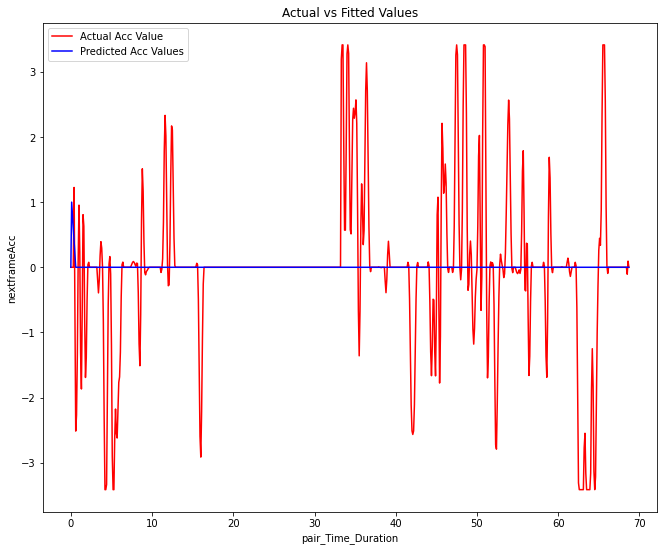

In [90]:
plt.figure(figsize=(11, 9))


ax = sns.lineplot(x=prediction1["pair_Time_Duration"], y = prediction1["nextframeAcc"], color="r", label="Actual Acc Value")
sns.lineplot(x=prediction1["pair_Time_Duration"], y =prediction1["predicted_acceleration"],  color="b", label="Predicted Acc Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()



In [ ]:
plt.figure(figsize=(11, 9))


ax = sns.lineplot(x=prediction1["pair_Time_Duration"], y = prediction1["nextframeAcc"], color="r", label="Actual Acc Value")
sns.lineplot(x=prediction1["pair_Time_Duration"], y =prediction1["predicted_acceleration"],  color="b", label="Predicted Acc Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [91]:
ngsim.columns

Index(['Local_Y', 'v_Class', 'v_Vel', 'v_Acc', 'Rear_to_Front_Space_Headway',
       'Front_To_Rear_Time_Headway', 'Velocity Difference_Following-Preceding',
       'Acceleration Difference_Following-Preceding', 'L-F_Pair',
       'preceding_vehicle_length', 'previous_Vehicle_Velocity',
       'previous_Vehicle_Acceleration', 'previous_Local_Y',
       'pair_Time_Duration', 'total_pair_duration', 'Vehicle_combination_cat',
       'Preceding_Vehicle_Class_cat', 'Location_cat', 'nextframeAcc',
       'nextframesvel', 'nextframeposition'],
      dtype='object')